# 1.7. Gaussian Processes
http://scikit-learn.org/stable/modules/gaussian_process.html

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Gaussian Processes (GP)** are a generic supervised learning method designed to solve regression and probabilistic classification problems.

The advantages of Gaussian processes are:

- The prediction interpolates the observations (at least for regular kernels).
- The prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals and decide based on those if one should refit (online fitting, adaptive fitting) the prediction in some region of interest.
- Versatile: different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of Gaussian processes include:

- They are not sparse, i.e., they use the whole samples/features information to perform the prediction.
- They lose efficiency in high dimensional spaces – namely when the number of features exceeds a few dozens.

## 1.7.1. Gaussian Process Regression (GPR)
The `GaussianProcessRegressor` implements Gaussian processes (GP) for regression purposes. For this, the prior of the GP needs to be specified. The prior mean is assumed to be constant and zero (for normalize_y=False) or the training data’s mean (for normalize_y=True). The prior’s covariance is specified by a passing a kernel object. The hyperparameters of the kernel are optimized during fitting of GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) based on the passed optimizer. As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer. The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, None can be passed as optimizer.

The noise level in the targets can be specified by passing it via the parameter alpha, either globally as a scalar or per datapoint. Note that a moderate noise level can also be helpful for dealing with numeric issues during fitting as it is effectively implemented as Tikhonov regularization, i.e., by adding it to the diagonal of the kernel matrix. An alternative to specifying the noise level explicitly is to include a WhiteKernel component into the kernel, which can estimate the global noise level from the data (see example below).

The implementation is based on Algorithm 2.1 of [RW2006]. In addition to the API of standard scikit-learn estimators, GaussianProcessRegressor:

- allows prediction without prior fitting (based on the GP prior)
- provides an additional method sample_y(X), which evaluates samples drawn from the GPR (prior or posterior) at given inputs
- exposes a method log_marginal_likelihood(theta), which can be used externally for other ways of selecting hyperparameters, e.g., via Markov chain Monte Carlo.

## 1.7.2. GPR examples
### 1.7.2.1. GPR with noise-level estimation
This example illustrates that GPR with a sum-kernel including a WhiteKernel can estimate the noise level of data. An illustration of the log-marginal-likelihood (LML) landscape shows that there exist two local maxima of LML.

### Gaussian process regression (GPR) with noise-level estimation
This example illustrates that GPR with a sum-kernel including a WhiteKernel can estimate the noise level of data. An illustration of the log-marginal-likelihood (LML) landscape shows that there exist two local maxima of LML. The first corresponds to a model with a high noise level and a large length scale, which explains all variations in the data by noise. The second one has a smaller noise level and shorter length scale, which explains most of the variation by the noise-free functional relationship. The second model has a higher likelihood; however, depending on the initial value for the hyperparameters, the gradient-based optimization might also converge to the high-noise solution. It is thus important to repeat the optimization several times for different initializations.

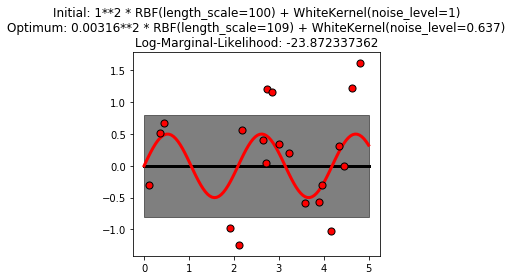

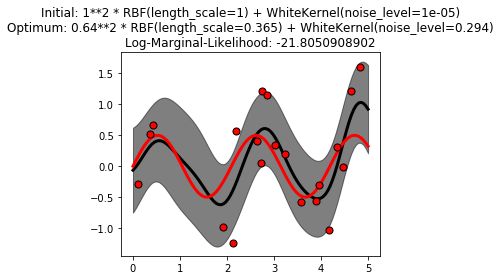

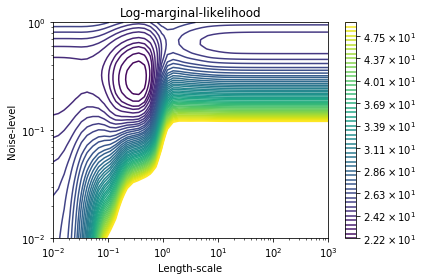

In [5]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

# First run ******************************************
plt.figure(0)

kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)

X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Second run ******************************************
plt.figure(1)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
    
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Plot LML landscape ******************************************
plt.figure(2)
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()

### 1.7.2.2. Comparison of GPR and Kernel Ridge Regression
Both kernel ridge regression (KRR) and Gaussian process regression (GPR) learn a target function by employing internally the “kernel trick”. KRR learns a linear function in the space induced by the respective kernel which corresponds to a non-linear function in the original space. The linear function in the kernel space is chosen based on the mean-squared error loss with ridge regularization. GPR uses the kernel to define the covariance of a prior distribution over the target functions and uses the observed training data to define a likelihood function. Based on Bayes theorem, a (Gaussian) posterior distribution over target functions is defined, whose mean is used for prediction.

A major difference is that GPR can choose the kernel’s hyperparameters based on gradient-ascent on the marginal likelihood function while KRR needs to perform a grid search on a cross-validated loss function (mean-squared error loss). A further difference is that GPR learns a generative, probabilistic model of the target function and can thus provide meaningful confidence intervals and posterior samples along with the predictions while KRR only provides predictions.

This example illustrates both methods on an artificial dataset, which consists of a sinusoidal target function and strong noise. The figure compares the learned model of KRR and GPR based on a ExpSineSquared kernel, which is suited for learning periodic functions. The kernel’s hyperparameters control the smoothness (l) and periodicity of the kernel (p). Moreover, the noise level of the data is learned explicitly by GPR by an additional WhiteKernel component in the kernel and by the regularization parameter alpha of KRR.

The figure shows that both methods learn reasonable models of the target function. GPR correctly identifies the periodicity of the function to be roughly 2*pi (6.28), while KRR chooses the doubled periodicity 4*pi. Besides that, GPR provides reasonable confidence bounds on the prediction which are not available for KRR. A major difference between the two methods is the time required for fitting and predicting: while fitting KRR is fast in principle, the grid-search for hyperparameter optimization scales exponentially with the number of hyperparameters (“curse of dimensionality”). The gradient-based optimization of the parameters in GPR does not suffer from this exponential scaling and is thus considerable faster on this example with 3-dimensional hyperparameter space. The time for predicting is similar; however, generating the variance of the predictive distribution of GPR takes considerable longer than just predicting the mean.

Time for KRR fitting: 3.358
Time for GPR fitting: 0.099
Time for KRR prediction: 0.043
Time for GPR prediction: 0.049
Time for GPR prediction with standard-deviation: 0.084


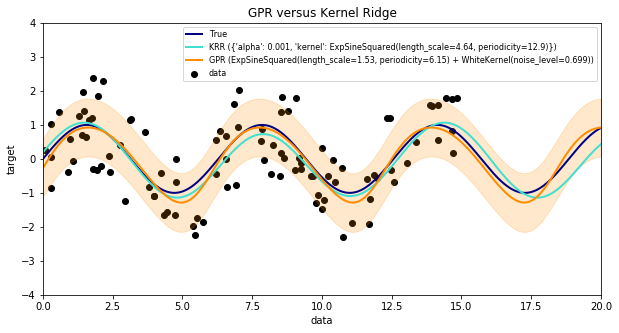

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = np.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
stime = time.time()
kr.fit(X, y)
print("Time for KRR fitting: %.3f" % (time.time() - stime))

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
    + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
stime = time.time()
gpr.fit(X, y)
print("Time for GPR fitting: %.3f" % (time.time() - stime))

# Predict using kernel ridge
X_plot = np.linspace(0, 20, 10000)[:, None]
stime = time.time()
y_kr = kr.predict(X_plot)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

# Predict using gaussian process regressor
stime = time.time()
y_gpr = gpr.predict(X_plot, return_std=False)
print("Time for GPR prediction: %.3f" % (time.time() - stime))

stime = time.time()
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
print("Time for GPR prediction with standard-deviation: %.3f"
      % (time.time() - stime))

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_kr, color='turquoise', lw=lw,
         label='KRR (%s)' % kr.best_params_)
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.title('GPR versus Kernel Ridge')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

### 1.7.2.3. GPR on Mauna Loa CO2 data
This example is based on Section 5.4.3 of [RW2006]. It illustrates an example of complex kernel engineering and hyperparameter optimization using gradient ascent on the log-marginal-likelihood. The data consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppmv)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 1997. The objective is to model the CO2 concentration as a function of the time t.

The kernel is composed of several terms that are responsible for explaining different properties of the signal:

- a long term, smooth rising trend is to be explained by an RBF kernel. The RBF kernel with a large length-scale enforces this component to be smooth; it is not enforced that the trend is rising which leaves this choice to the GP. The specific length-scale and the amplitude are free hyperparameters.
- a seasonal component, which is to be explained by the periodic ExpSineSquared kernel with a fixed periodicity of 1 year. The length-scale of this periodic component, controlling its smoothness, is a free parameter. In order to allow decaying away from exact periodicity, the product with an RBF kernel is taken. The length-scale of this RBF component controls the decay time and is a further free parameter.
- smaller, medium term irregularities are to be explained by a RationalQuadratic kernel component, whose length-scale and alpha parameter, which determines the diffuseness of the length-scales, are to be determined. According to [RW2006], these irregularities can better be explained by a RationalQuadratic than an RBF kernel component, probably because it can accommodate several length-scales.
- a “noise” term, consisting of an RBF kernel contribution, which shall explain the correlated noise components such as local weather phenomena, and a WhiteKernel contribution for the white noise. The relative amplitudes and the RBF’s length scale are further free parameters.  

Maximizing the log-marginal-likelihood after subtracting the target’s mean yields the following kernel with an LML of -83.214:
```
34.4**2 * RBF(length_scale=41.8)
+ 3.27**2 * RBF(length_scale=180) * ExpSineSquared(length_scale=1.44,
                                                   periodicity=1)
+ 0.446**2 * RationalQuadratic(alpha=17.7, length_scale=0.957)
+ 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)
```
Thus, most of the target signal (34.4ppm) is explained by a long-term rising trend (length-scale 41.8 years). The periodic component has an amplitude of 3.27ppm, a decay time of 180 years and a length-scale of 1.44. The long decay time indicates that we have a locally very close to periodic seasonal component. The correlated noise has an amplitude of 0.197ppm with a length scale of 0.138 years and a white-noise contribution of 0.197ppm. Thus, the overall noise level is very small, indicating that the data can be very well explained by the model. The figure shows also that the model makes very confident predictions until around 2015

GPML kernel: 66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: -87.034

Learned kernel: 34.5**2 * RBF(length_scale=41.8) + 3.27**2 * RBF(length_scale=180) * ExpSineSquared(length_scale=1.44, periodicity=1) + 0.446**2 * RationalQuadratic(alpha=17.6, length_scale=0.957) + 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)
Log-marginal-likelihood: -83.214


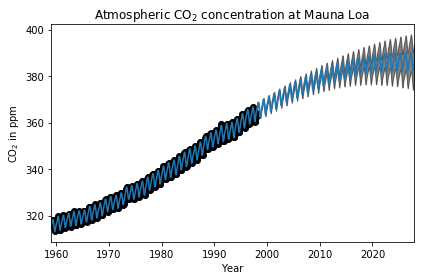

In [7]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.datasets import fetch_mldata

data = fetch_mldata('mauna-loa-atmospheric-co2').data
X = data[:, [1]]
y = data[:, 0]

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

## 1.7.3. Gaussian Process Classification (GPC)
The GaussianProcessClassifier implements Gaussian processes (GP) for classification purposes, more specifically for probabilistic classification, where test predictions take the form of class probabilities. GaussianProcessClassifier places a GP prior on a latent function f, which is then squashed through a link function to obtain the probabilistic classification. The latent function f is a so-called nuisance function, whose values are not observed and are not relevant by themselves. Its purpose is to allow a convenient formulation of the model, and f is removed (integrated out) during prediction. GaussianProcessClassifier implements the logistic link function, for which the integral cannot be computed analytically but is easily approximated in the binary case.

In contrast to the regression setting, the posterior of the latent function f is not Gaussian even for a GP prior since a Gaussian likelihood is inappropriate for discrete class labels. Rather, a non-Gaussian likelihood corresponding to the logistic link function (logit) is used. GaussianProcessClassifier approximates the non-Gaussian posterior with a Gaussian based on the Laplace approximation. More details can be found in Chapter 3 of [RW2006].

The GP prior mean is assumed to be zero. The prior’s covariance is specified by a passing a kernel object. The hyperparameters of the kernel are optimized during fitting of GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) based on the passed optimizer. As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer. The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, None can be passed as optimizer.

GaussianProcessClassifier supports multi-class classification by performing either one-versus-rest or one-versus-one based training and prediction. In one-versus-rest, one binary Gaussian process classifier is fitted for each class, which is trained to separate this class from the rest. In “one_vs_one”, one binary Gaussian process classifier is fitted for each pair of classes, which is trained to separate these two classes. The predictions of these binary predictors are combined into multi-class predictions. See the section on multi-class classification for more details.

In the case of Gaussian process classification, “one_vs_one” might be computationally cheaper since it has to solve many problems involving only a subset of the whole training set rather than fewer problems on the whole dataset. Since Gaussian process classification scales cubically with the size of the dataset, this might be considerably faster. However, note that “one_vs_one” does not support predicting probability estimates but only plain predictions. Moreover, note that GaussianProcessClassifier does not (yet) implement a true multi-class Laplace approximation internally, but as discussed above is based on solving several binary classification tasks internally, which are combined using one-versus-rest or one-versus-one.

## 1.7.4. GPC examples
### 1.7.4.1. Probabilistic predictions with GPC
This example illustrates the predicted probability of GPC for an RBF kernel with different choices of the hyperparameters. The first figure shows the predicted probability of GPC with arbitrarily chosen hyperparameters and with the hyperparameters corresponding to the maximum log-marginal-likelihood (LML).

While the hyperparameters chosen by optimizing LML have a considerable larger LML, they perform slightly worse according to the log-loss on test data. The figure shows that this is because they exhibit a steep change of the class probabilities at the class boundaries (which is good) but have predicted probabilities close to 0.5 far away from the class boundaries (which is bad) This undesirable effect is caused by the Laplace approximation used internally by GPC.

The second figure shows the log-marginal-likelihood for different choices of the kernel’s hyperparameters, highlighting the two choices of the hyperparameters used in the first figure by black dots.

Log Marginal Likelihood (initial): -17.598
Log Marginal Likelihood (optimized): -3.875
Accuracy: 1.000 (initial) 1.000 (optimized)
Log-loss: 0.214 (initial) 0.319 (optimized)


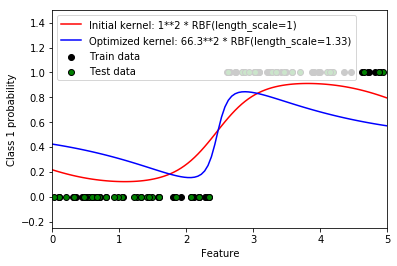

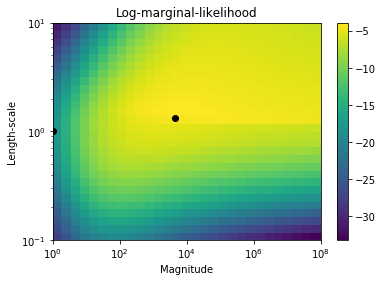

In [8]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


# Generate data
train_size = 50
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 100)[:, np.newaxis]
y = np.array(X[:, 0] > 2.5, dtype=int)

# Specify Gaussian Processes with fixed and optimized hyperparameters
gp_fix = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0),
                                   optimizer=None)
gp_fix.fit(X[:train_size], y[:train_size])

gp_opt = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
gp_opt.fit(X[:train_size], y[:train_size])

print("Log Marginal Likelihood (initial): %.3f"
      % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta))
print("Log Marginal Likelihood (optimized): %.3f"
      % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta))

print("Accuracy: %.3f (initial) %.3f (optimized)"
      % (accuracy_score(y[:train_size], gp_fix.predict(X[:train_size])),
         accuracy_score(y[:train_size], gp_opt.predict(X[:train_size]))))
print("Log-loss: %.3f (initial) %.3f (optimized)"
      % (log_loss(y[:train_size], gp_fix.predict_proba(X[:train_size])[:, 1]),
         log_loss(y[:train_size], gp_opt.predict_proba(X[:train_size])[:, 1])))


# Plot posteriors
plt.figure(0)
plt.scatter(X[:train_size, 0], y[:train_size], c='k', label="Train data",
            edgecolors=(0, 0, 0))
plt.scatter(X[train_size:, 0], y[train_size:], c='g', label="Test data",
            edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
plt.plot(X_, gp_fix.predict_proba(X_[:, np.newaxis])[:, 1], 'r',
         label="Initial kernel: %s" % gp_fix.kernel_)
plt.plot(X_, gp_opt.predict_proba(X_[:, np.newaxis])[:, 1], 'b',
         label="Optimized kernel: %s" % gp_opt.kernel_)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

# Plot LML landscape
plt.figure(1)
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T
plt.plot(np.exp(gp_fix.kernel_.theta)[0], np.exp(gp_fix.kernel_.theta)[1],
         'ko', zorder=10)
plt.plot(np.exp(gp_opt.kernel_.theta)[0], np.exp(gp_opt.kernel_.theta)[1],
         'ko', zorder=10)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")

plt.show()

### 1.7.4.2. Illustration of GPC on the XOR dataset
This example illustrates GPC on XOR data. Compared are a stationary, isotropic kernel (RBF) and a non-stationary kernel (DotProduct). On this particular dataset, the DotProduct kernel obtains considerably better results because the class-boundaries are linear and coincide with the coordinate axes. In practice, however, stationary kernels such as RBF often obtain better results.

C:\Softwares\Python\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
C:\Softwares\Python\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


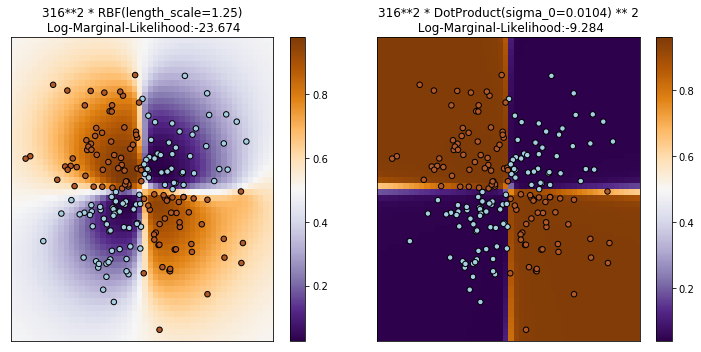

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct


xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
plt.figure(figsize=(10, 5))
kernels = [1.0 * RBF(length_scale=1.0), 1.0 * DotProduct(sigma_0=1.0)**2]
for i, kernel in enumerate(kernels):
    clf = GaussianProcessClassifier(kernel=kernel, warm_start=True).fit(X, Y)

    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    plt.subplot(1, 2, i + 1)
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                           linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))
    plt.xticks(())
    plt.yticks(())
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title("%s\n Log-Marginal-Likelihood:%.3f"
              % (clf.kernel_, clf.log_marginal_likelihood(clf.kernel_.theta)),
              fontsize=12)

plt.tight_layout()
plt.show()

### 1.7.4.3. Gaussian process classification (GPC) on iris dataset
This example illustrates the predicted probability of GPC for an isotropic and anisotropic RBF kernel on a two-dimensional version for the iris-dataset. This illustrates the applicability of GPC to non-binary classification. The anisotropic RBF kernel obtains slightly higher log-marginal-likelihood by assigning different length-scales to the two feature dimensions.

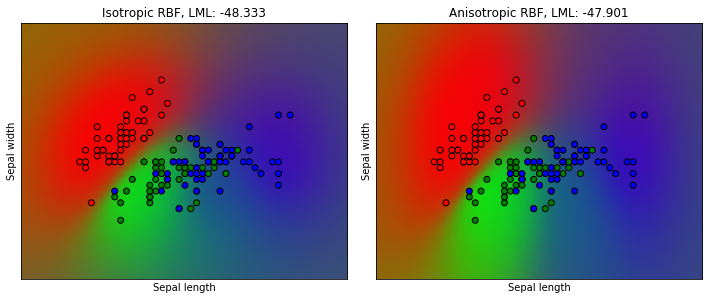

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = np.array(iris.target, dtype=int)

h = .02  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)
kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y],
                edgecolors=(0, 0, 0))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("%s, LML: %.3f" %
              (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta)))

plt.tight_layout()
plt.show()

## 1.7.5. Kernels for Gaussian Processes
Kernels (also called “covariance functions” in the context of GPs) are a crucial ingredient of GPs which determine the shape of prior and posterior of the GP. They encode the assumptions on the function being learned by defining the “similarity” of two datapoints combined with the assumption that similar datapoints should have similar target values. Two categories of kernels can be distinguished: stationary kernels depend only on the distance of two datapoints and not on their absolute values k(x_i, x_j)= k(d(x_i, x_j)) and are thus invariant to translations in the input space, while non-stationary kernels depend also on the specific values of the datapoints. Stationary kernels can further be subdivided into isotropic and anisotropic kernels, where isotropic kernels are also invariant to rotations in the input space. For more details, we refer to Chapter 4 of [RW2006].

### 1.7.5.1. Gaussian Process Kernel API
The main usage of a Kernel is to compute the GP’s covariance between datapoints. For this, the method __call__ of the kernel can be called. This method can either be used to compute the “auto-covariance” of all pairs of datapoints in a 2d array X, or the “cross-covariance” of all combinations of datapoints of a 2d array X with datapoints in a 2d array Y. The following identity holds true for all kernels k (except for the WhiteKernel): k(X) == K(X, Y=X)

If only the diagonal of the auto-covariance is being used, the method diag() of a kernel can be called, which is more computationally efficient than the equivalent call to __call__: np.diag(k(X, X)) == k.diag(X)

Kernels are parameterized by a vector \theta of hyperparameters. These hyperparameters can for instance control length-scales or periodicity of a kernel (see below). All kernels support computing analytic gradients of of the kernel’s auto-covariance with respect to \theta via setting eval_gradient=True in the __call__ method. This gradient is used by the Gaussian process (both regressor and classifier) in computing the gradient of the log-marginal-likelihood, which in turn is used to determine the value of \theta, which maximizes the log-marginal-likelihood, via gradient ascent. For each hyperparameter, the initial value and the bounds need to be specified when creating an instance of the kernel. The current value of \theta can be get and set via the property theta of the kernel object. Moreover, the bounds of the hyperparameters can be accessed by the property bounds of the kernel. Note that both properties (theta and bounds) return log-transformed values of the internally used values since those are typically more amenable to gradient-based optimization. The specification of each hyperparameter is stored in the form of an instance of Hyperparameter in the respective kernel. Note that a kernel using a hyperparameter with name “x” must have the attributes self.x and self.x_bounds.

The abstract base class for all kernels is Kernel. Kernel implements a similar interface as Estimator, providing the methods get_params(), set_params(), and clone(). This allows setting kernel values also via meta-estimators such as Pipeline or GridSearch. Note that due to the nested structure of kernels (by applying kernel operators, see below), the names of kernel parameters might become relatively complicated. In general, for a binary kernel operator, parameters of the left operand are prefixed with k1__ and parameters of the right operand with k2__. An additional convenience method is clone_with_theta(theta), which returns a cloned version of the kernel but with the hyperparameters set to theta. An illustrative example:

In [11]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))
for hyperparameter in kernel.hyperparameters: print(hyperparameter)

Hyperparameter(name='k1__k1__constant_value', value_type='numeric', bounds=array([[  0.,  10.]]), n_elements=1, fixed=False)
Hyperparameter(name='k1__k2__length_scale', value_type='numeric', bounds=array([[  0.,  10.]]), n_elements=1, fixed=False)
Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[  0.,  10.]]), n_elements=1, fixed=False)


In [12]:
params = kernel.get_params()
for key in sorted(params): print("%s : %s" % (key, params[key]))

k1 : 1**2 * RBF(length_scale=0.5)
k1__k1 : 1**2
k1__k1__constant_value : 1.0
k1__k1__constant_value_bounds : (0.0, 10.0)
k1__k2 : RBF(length_scale=0.5)
k1__k2__length_scale : 0.5
k1__k2__length_scale_bounds : (0.0, 10.0)
k2 : RBF(length_scale=2)
k2__length_scale : 2.0
k2__length_scale_bounds : (0.0, 10.0)


In [13]:
print(kernel.theta)  # Note: log-transformed

[ 0.         -0.69314718  0.69314718]


In [14]:
print(kernel.bounds)  # Note: log-transformed

[[       -inf  2.30258509]
 [       -inf  2.30258509]
 [       -inf  2.30258509]]


C:\Softwares\Python\lib\site-packages\sklearn\gaussian_process\kernels.py:288: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


All Gaussian process kernels are interoperable with sklearn.metrics.pairwise and vice versa: instances of subclasses of Kernel can be passed as metric to `pairwise_kernels` from sklearn.metrics.pairwise. Moreover, kernel functions from pairwise can be used as GP kernels by using the wrapper class PairwiseKernel. The only caveat is that the gradient of the hyperparameters is not analytic but numeric and all those kernels support only isotropic distances. The parameter gamma is considered to be a hyperparameter and may be optimized. The other kernel parameters are set directly at initialization and are kept fixed.

### 1.7.5.2. Basic kernels
The ConstantKernel kernel can be used as part of a Product kernel where it scales the magnitude of the other factor (kernel) or as part of a Sum kernel, where it modifies the mean of the Gaussian process. It depends on a parameter constant\_value. It is defined as:

$k(x_i, x_j) = constant\_value \;\forall\; x_1, x_2$

The main use-case of the WhiteKernel kernel is as part of a sum-kernel where it explains the noise-component of the signal. Tuning its parameter noise\_level corresponds to estimating the noise-level. It is defined as:e

$k(x_i, x_j) = noise\_level \text{ if } x_i == x_j \text{ else } 0$

### 1.7.5.3. Kernel operators
Kernel operators take one or two base kernels and combine them into a new kernel. The Sum kernel takes two kernels k1 and k2 and combines them via $k_{sum}(X, Y) = k1(X, Y) + k2(X, Y)$. The Product kernel takes two kernels k1 and k2 and combines them via $k_{product}(X, Y) = k1(X, Y) * k2(X, Y)$. The Exponentiation kernel takes one base kernel and a scalar parameter exponent and combines them via $k_{exp}(X, Y) = k(X, Y)^\text{exponent}$.

### 1.7.5.4. Radial-basis function (RBF) kernel
The RBF kernel is a stationary kernel. It is also known as the “squared exponential” kernel. It is parameterized by a length-scale parameter l>0, which can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs x (anisotropic variant of the kernel). The kernel is given by:

$k(x_i, x_j) = \text{exp}\left(-\frac{1}{2} d(x_i / l, x_j / l)^2\right)$

This kernel is infinitely differentiable, which implies that GPs with this kernel as covariance function have mean square derivatives of all orders, and are thus very smooth. The prior and posterior of a GP resulting from an RBF kernel are shown in the following figure:

### Illustration of prior and posterior Gaussian process for different kernels
This example illustrates the prior and posterior of a GPR with different kernels. Mean, standard deviation, and 10 samples are shown for both prior and posterior.

C:\Softwares\Python\lib\site-packages\sklearn\gaussian_process\gpr.py:369: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
C:\Softwares\Python\lib\site-packages\sklearn\gaussian_process\kernels.py:288: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Softwares\Python\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


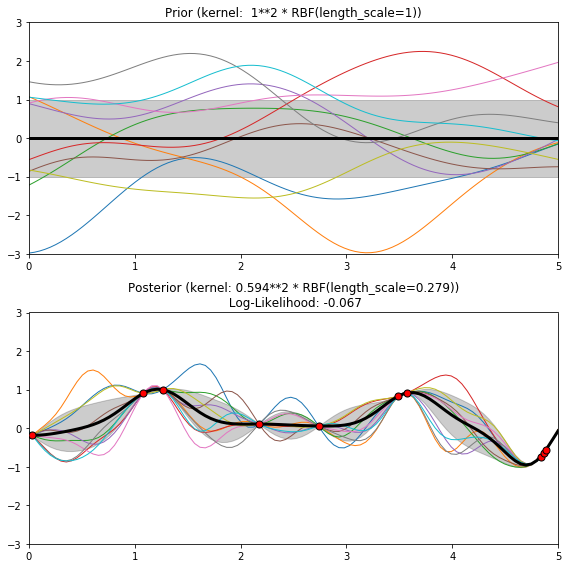

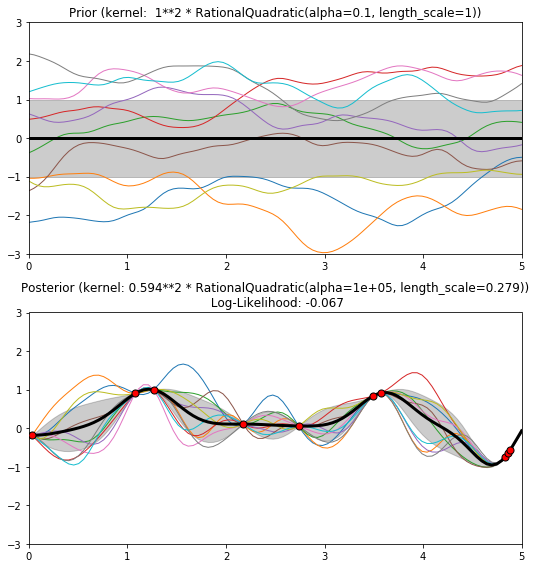

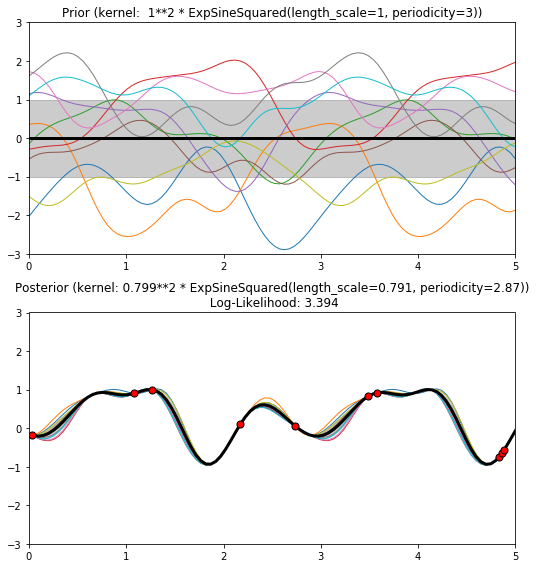

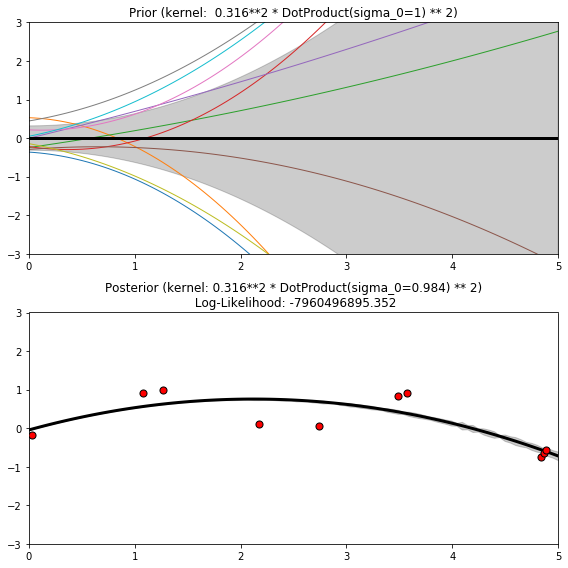

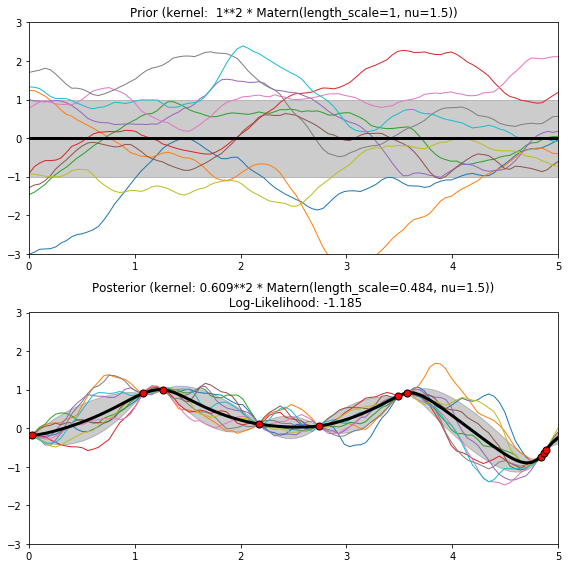

In [16]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(fig_index, figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

### 1.7.5.5. Matérn kernel
The Matern kernel is a stationary kernel and a generalization of the RBF kernel. It has an additional parameter \nu which controls the smoothness of the resulting function. It is parameterized by a length-scale parameter l>0, which can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs x (anisotropic variant of the kernel). The kernel is given by:

$k(x_i, x_j) = \sigma^2\frac{1}{\Gamma(\nu)2^{\nu-1}}\Bigg(\gamma\sqrt{2\nu} d(x_i / l, x_j / l)\Bigg)^\nu K_\nu\Bigg(\gamma\sqrt{2\nu} d(x_i / l, x_j / l)\Bigg)$,

As $\nu\rightarrow\infty$, the Matérn kernel converges to the RBF kernel. When $\nu = 1/2$, the Matérn kernel becomes identical to the absolute exponential kernel, i.e.,

$k(x_i, x_j) = \sigma^2 \exp \Bigg(-\gamma d(x_i / l, x_j / l) \Bigg) \quad \quad \nu= \tfrac{1}{2}$

In particular, $\nu = 3/2$:

$k(x_i, x_j) = \sigma^2 \Bigg(1 + \gamma \sqrt{3} d(x_i / l, x_j / l)\Bigg) \exp \Bigg(-\gamma \sqrt{3}d(x_i / l, x_j / l) \Bigg) \quad \quad \nu= \tfrac{3}{2}$

and $\nu = 5/2$:

$k(x_i, x_j) = \sigma^2 \Bigg(1 + \gamma \sqrt{5}d(x_i / l, x_j / l) +\frac{5}{3} \gamma^2d(x_i / l, x_j / l)^2 \Bigg) \exp \Bigg(-\gamma \sqrt{5}d(x_i / l, x_j / l) \Bigg) \quad \quad \nu= \tfrac{5}{2}$

are popular choices for learning functions that are not infinitely differentiable (as assumed by the RBF kernel) but at least once ($\nu = 3/2$) or twice differentiable ($\nu = 5/2$).

The flexibility of controlling the smoothness of the learned function via \nu allows adapting to the properties of the true underlying functional relation. The prior and posterior of a GP resulting from a Matérn kernel are shown in the following figure:

### 1.7.5.6. Rational quadratic kernel
The RationalQuadratic kernel can be seen as a scale mixture (an infinite sum) of RBF kernels with different characteristic length-scales. It is parameterized by a length-scale parameter $l>0$ and a scale mixture parameter  $\alpha>0$ Only the isotropic variant where l is a scalar is supported at the moment. The kernel is given by:

$k(x_i, x_j) = \left(1 + \frac{d(x_i, x_j)^2}{2\alpha l^2}\right)^{-\alpha}$

The prior and posterior of a GP resulting from an RBF kernel are shown in the following figure:

### 1.7.5.7. Exp-Sine-Squared kernel
The ExpSineSquared kernel allows modeling periodic functions. It is parameterized by a length-scale parameter l>0 and a periodicity parameter p>0. Only the isotropic variant where l is a scalar is supported at the moment. The kernel is given by:

$k(x_i, x_j) = \text{exp}\left(-2 \left(\text{sin}(\pi / p * d(x_i, x_j)) / l\right)^2\right)$

The prior and posterior of a GP resulting from an ExpSineSquared kernel are shown in the following figure:

### 1.7.5.8. Dot-Product kernel
The DotProduct kernel is non-stationary and can be obtained from linear regression by putting $N(0, 1)$ priors on the coefficients of $x_d (d = 1, . . . , D)$ and a prior of $N(0, \sigma_0^2)$ on the bias. The DotProduct kernel is invariant to a rotation of the coordinates about the origin, but not translations. It is parameterized by a parameter $\sigma_0^2$. For $\sigma_0^2 = 0$, the kernel is called the homogeneous linear kernel, otherwise it is inhomogeneous. The kernel is given by

$k(x_i, x_j) = \sigma_0 ^ 2 + x_i \cdot x_j$

The DotProduct kernel is commonly combined with exponentiation. An example with exponent 2 is shown in the following figure: